# **Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy import sparse
from scipy.sparse import hstack
import pandas as pd
import numpy as np
import nltk
import math
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import Ridge
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import math
from lightgbm import LGBMRegressor
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import os
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Oct 27 13:26:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    54W / 300W |  15357MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# **Data Encoding**

In [ ]:
X= pd.read_pickle('/content/drive/My Drive/Kaggle/Mercari/approach_1/X.pkl')
X_train=pd.read_pickle('/content/drive/My Drive/Kaggle/Mercari/approach_1/X_train.pkl')
X_test=pd.read_pickle('/content/drive/My Drive/Kaggle/Mercari/approach_1/X_test.pkl')
y_train=pd.read_pickle('/content/drive/My Drive/Kaggle/Mercari/approach_1/y_train.pkl')
y_test=pd.read_pickle('/content/drive/My Drive/Kaggle/Mercari/approach_1/y_test.pkl')

In [ ]:
X_train = X_train[:500000]
X_test = X_test[:200000]
y_train = y_train[:500000]
y_test = y_test[:200000]

In [ ]:
def encoding_categorical_variables(col,X_train,X_test,df):
  
  """ One hot Encode Categorical Variables using countvectorizer """
  
  from collections import Counter
  my_counter = Counter()
  for word in df[col].astype(str).values:
      my_counter.update(word.split())

  cat_dict = dict(my_counter)
  sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
  X_train_cat = vectorizer.transform(X_train[col].values)
  X_test_cat = vectorizer.transform(X_test[col].values)
  
  return X_train_cat ,X_test_cat

In [ ]:
def scaling_numerical_features(col,df_train,df_test):
  
  """ Normalizin Numerical Variables """

  from sklearn.preprocessing import Normalizer
  normalizer = Normalizer()
  normalizer.fit(df_train[col].values.reshape(-1,1))

  train_norm = normalizer.transform(df_train[col].values.reshape(-1,1))
  test_norm = normalizer.transform(df_test[col].values.reshape(-1,1))

  return train_norm , test_norm

In [ ]:
def encoding_numerical_categories(col,X_train,X_test):
  from sklearn.preprocessing import OneHotEncoder
  enc = OneHotEncoder()
  enc.fit(X_train[col].values.reshape(-1, 1))
  X_train_enc = enc.transform(X_train[col].values.reshape(-1, 1))
  X_test_enc = enc.transform(X_test[col].values.reshape(-1, 1))

  return X_train_enc,X_test_enc

In [ ]:
def avg_w2_vec_encoding(col,df):
  """ AVG_W2V Encoding"""

  with open('/content/drive/My Drive/Assignments_DonorsChoose_2018/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

  X_avg_w2v = [];
  for sentence in tqdm(df[col].values):
      vector = np.zeros(300)
      cnt_words =0; 
      for word in sentence.split():
          if word in glove_words:
              vector += model[word]
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      X_avg_w2v.append(vector)

  return X_avg_w2v

In [ ]:
def tfidf_avg_w2v_encoding(col,df):
  with open('/content/drive/My Drive/Assignments_DonorsChoose_2018/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

  tfidf_model = TfidfVectorizer()
  tfidf_model.fit(df[col].values)
  dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
  tfidf_words = set(tfidf_model.get_feature_names())

  X_tfidf_W2V = [];
  for sentence in tqdm(df[col].values):
      vector = np.zeros(300)
      tf_idf_weight =0;
      for word in sentence.split():
          if (word in glove_words) and (word in tfidf_words):
              vec = model[word] 
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) 
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      X_tfidf_W2V.append(vector)

  return X_tfidf_W2V

In [ ]:
def tfidf_vect(col,X_train,X_test):

  vectorizer = TfidfVectorizer()
  vectorizer.fit(X_train[col].values) 

  X_train_essay_tfidf = vectorizer.transform(X_train[col].values)
  
  X_test_essay_tfidf = vectorizer.transform(X_test[col].values)

  return X_train_essay_tfidf,X_test_essay_tfidf

In [ ]:
def data_preprocessing_avg_W2V(X_train,X_test):

  X_train_brand_name,X_test_brand_name=encoding_categorical_variables('brand_name',X_train,X_test,X)
  X_train_category1,X_test_category1=encoding_categorical_variables('category1',X_train,X_test,X)
  X_train_category2,X_test_category2=encoding_categorical_variables('category2',X_train,X_test,X)
  X_train_category3,X_test_category3=encoding_categorical_variables('category3',X_train,X_test,X)
  X_train_category4,X_test_category4=encoding_categorical_variables('category4',X_train,X_test,X)
  X_train_category5,X_test_category5=encoding_categorical_variables('category5',X_train,X_test,X)

  X_train_wordsitem_description,X_test_wordsitem_description=scaling_numerical_features('No_of_wordsitem_description',X_train,X_test)
  X_train_charsitem_description,X_test_charsitem_description=scaling_numerical_features('No_of_charsitem_description',X_train,X_test)
  X_train_len_item_description,X_test_len_item_description=scaling_numerical_features('Avg_len_item_description',X_train,X_test)
  X_train_stop_wordsitem_description,X_test_stop_wordsitem_description=scaling_numerical_features('No_of_stop_wordsitem_description',X_train,X_test)
  X_train_digitsitem_description,X_test_digitsitem_description=scaling_numerical_features('No_of_digitsitem_description',X_train,X_test)
  X_train_upper_caseditem_description,X_test_upper_caseditem_description=scaling_numerical_features('No_of_upper_caseditem_description',X_train,X_test)
  X_train_lower_caseditem_description,X_test_lower_caseditem_description=scaling_numerical_features('No_of_lower_caseditem_description',X_train,X_test)

  X_train_wordsname,X_test_wordsname=scaling_numerical_features('No_of_wordsname',X_train,X_test)
  X_train_charsname,X_test_charsname=scaling_numerical_features('No_of_charsname',X_train,X_test)
  X_train_len_name,X_test_len_name=scaling_numerical_features('Avg_len_name',X_train,X_test)
  X_train_stop_wordsname,X_test_stop_wordsname=scaling_numerical_features('No_of_stop_wordsname',X_train,X_test)
  X_train_digitsname,X_test_digitsname=scaling_numerical_features('No_of_digitsname',X_train,X_test)
  X_train_upper_casedname,X_test_upper_casedname=scaling_numerical_features('No_of_upper_casedname',X_train,X_test)
  X_train_lower_casedname,X_test_upper_lower_casedname=scaling_numerical_features('No_of_lower_casedname',X_train,X_test)
  X_train_enc_shipping,X_test_enc_shipping = encoding_numerical_categories('shipping',X_train,X_test)
  X_train_enc_item_condition,X_test_enc_item_condition = encoding_numerical_categories('item_condition_id',X_train,X_test)

  X_train_prod_name_avg_w2v=avg_w2_vec_encoding('product_name_preprocessed',X_train)
  X_test_prod_name_avg_w2v=avg_w2_vec_encoding('product_name_preprocessed',X_test)
  X_train_item_desc_avg_w2v=avg_w2_vec_encoding('item_description_preprocessed',X_train)
  X_test_item_desc_avg_w2v=avg_w2_vec_encoding('item_description_preprocessed',X_test)


  X_tr_avg_W2Ve = hstack((X_train_prod_name_avg_w2v,X_train_item_desc_avg_w2v,X_train_brand_name,X_train_category1,X_train_category2,X_train_category3,X_train_category4,X_train_category5,X_train_wordsitem_description,X_train_charsitem_description,	X_train_len_item_description,X_train_stop_wordsitem_description,X_train_digitsitem_description,X_train_upper_caseditem_description,X_train_lower_caseditem_description,X_train_wordsname,X_train_charsname,X_train_len_name,X_train_stop_wordsname,X_train_digitsname,X_train_upper_casedname,X_train_lower_casedname,X_train_enc_shipping,X_train_enc_item_condition)).tocsr()
  X_te_avg_W2Ve = hstack((X_test_prod_name_avg_w2v,X_test_item_desc_avg_w2v,X_test_brand_name,X_test_category1,X_test_category2,X_test_category3,X_test_category4,X_test_category5,X_test_charsitem_description,X_test_len_item_description,X_test_stop_wordsitem_description,X_test_digitsitem_description,X_test_upper_caseditem_description,X_test_lower_caseditem_description,X_test_wordsitem_description,X_test_wordsname,X_test_charsname,X_test_len_name,X_test_stop_wordsname,X_test_digitsname,X_test_upper_casedname,X_test_upper_lower_casedname,X_test_enc_shipping,X_test_enc_item_condition)).tocsr()



  return X_tr_avg_W2Ve , X_te_avg_W2Ve 

In [ ]:
def data_preprocessing_tfidf_W2V(X_train,X_test):

  X_train_brand_name,X_test_brand_name=encoding_categorical_variables('brand_name',X_train,X_test,X)
  X_train_category1,X_test_category1=encoding_categorical_variables('category1',X_train,X_test,X)
  X_train_category2,X_test_category2=encoding_categorical_variables('category2',X_train,X_test,X)
  X_train_category3,X_test_category3=encoding_categorical_variables('category3',X_train,X_test,X)
  X_train_category4,X_test_category4=encoding_categorical_variables('category4',X_train,X_test,X)
  X_train_category5,X_test_category5=encoding_categorical_variables('category5',X_train,X_test,X)

  X_train_wordsitem_description,X_test_wordsitem_description=scaling_numerical_features('No_of_wordsitem_description',X_train,X_test)
  X_train_charsitem_description,X_test_charsitem_description=scaling_numerical_features('No_of_charsitem_description',X_train,X_test)
  X_train_len_item_description,X_test_len_item_description=scaling_numerical_features('Avg_len_item_description',X_train,X_test)
  X_train_stop_wordsitem_description,X_test_stop_wordsitem_description=scaling_numerical_features('No_of_stop_wordsitem_description',X_train,X_test)
  X_train_digitsitem_description,X_test_digitsitem_description=scaling_numerical_features('No_of_digitsitem_description',X_train,X_test)
  X_train_upper_caseditem_description,X_test_upper_caseditem_description=scaling_numerical_features('No_of_upper_caseditem_description',X_train,X_test)
  X_train_lower_caseditem_description,X_test_lower_caseditem_description=scaling_numerical_features('No_of_lower_caseditem_description',X_train,X_test)

  X_train_wordsname,X_test_wordsname=scaling_numerical_features('No_of_wordsname',X_train,X_test)
  X_train_charsname,X_test_charsname=scaling_numerical_features('No_of_charsname',X_train,X_test)
  X_train_len_name,X_test_len_name=scaling_numerical_features('Avg_len_name',X_train,X_test)
  X_train_stop_wordsname,X_test_stop_wordsname=scaling_numerical_features('No_of_stop_wordsname',X_train,X_test)
  X_train_digitsname,X_test_digitsname=scaling_numerical_features('No_of_digitsname',X_train,X_test)
  X_train_upper_casedname,X_test_upper_casedname=scaling_numerical_features('No_of_upper_casedname',X_train,X_test)
  X_train_lower_casedname,X_test_upper_lower_casedname=scaling_numerical_features('No_of_lower_casedname',X_train,X_test)
  X_train_enc_shipping,X_test_enc_shipping = encoding_numerical_categories('shipping',X_train,X_test)
  X_train_enc_item_condition,X_test_enc_item_condition = encoding_numerical_categories('item_condition_id',X_train,X_test)

  X_train_prod_name_tfidf_w2v=tfidf_avg_w2v_encoding('product_name_preprocessed',X_train)
  X_test_prod_name_tfidf_w2v=tfidf_avg_w2v_encoding('product_name_preprocessed',X_test)
  X_train_item_desc_tfidf_W2V=tfidf_avg_w2v_encoding('item_description_preprocessed',X_train)
  X_test_item_desc_tfidf_W2V=tfidf_avg_w2v_encoding('item_description_preprocessed',X_test)
  

  X_tr_tfidf_W2V = hstack((X_train_prod_name_tfidf_w2v,X_train_item_desc_tfidf_W2V,X_train_brand_name,X_train_category1,X_train_category2,X_train_category3,X_train_category4,X_train_category5,X_train_wordsitem_description,X_train_charsitem_description,	X_train_len_item_description,X_train_stop_wordsitem_description,X_train_digitsitem_description,X_train_upper_caseditem_description,X_train_lower_caseditem_description,X_train_wordsname,X_train_charsname,X_train_len_name,X_train_stop_wordsname,X_train_digitsname,X_train_upper_casedname,X_train_lower_casedname,X_train_enc_shipping,X_train_enc_item_condition)).tocsr()
  X_te_tfidf_W2V = hstack((X_test_prod_name_tfidf_w2v,X_test_item_desc_tfidf_W2V,X_test_brand_name,X_test_category1,X_test_category2,X_test_category3,X_test_category4,X_test_category5,X_test_charsitem_description,X_test_len_item_description,X_test_stop_wordsitem_description,X_test_digitsitem_description,X_test_upper_caseditem_description,X_test_lower_caseditem_description,X_test_wordsitem_description,X_test_wordsname,X_test_charsname,X_test_len_name,X_test_stop_wordsname,X_test_digitsname,X_test_upper_casedname,X_test_upper_lower_casedname,X_test_enc_shipping,X_test_enc_item_condition)).tocsr()


  return X_tr_tfidf_W2V , X_te_tfidf_W2V 

In [ ]:
def data_preprocessing_tfidf(X_train,X_test):

  X_train_brand_name,X_test_brand_name=encoding_categorical_variables('brand_name',X_train,X_test,X)
  X_train_category1,X_test_category1=encoding_categorical_variables('category1',X_train,X_test,X)
  X_train_category2,X_test_category2=encoding_categorical_variables('category2',X_train,X_test,X)
  X_train_category3,X_test_category3=encoding_categorical_variables('category3',X_train,X_test,X)
  X_train_category4,X_test_category4=encoding_categorical_variables('category4',X_train,X_test,X)
  X_train_category5,X_test_category5=encoding_categorical_variables('category5',X_train,X_test,X)

  X_train_wordsitem_description,X_test_wordsitem_description=scaling_numerical_features('No_of_wordsitem_description',X_train,X_test)
  X_train_charsitem_description,X_test_charsitem_description=scaling_numerical_features('No_of_charsitem_description',X_train,X_test)
  X_train_len_item_description,X_test_len_item_description=scaling_numerical_features('Avg_len_item_description',X_train,X_test)
  X_train_stop_wordsitem_description,X_test_stop_wordsitem_description=scaling_numerical_features('No_of_stop_wordsitem_description',X_train,X_test)
  X_train_digitsitem_description,X_test_digitsitem_description=scaling_numerical_features('No_of_digitsitem_description',X_train,X_test)
  X_train_upper_caseditem_description,X_test_upper_caseditem_description=scaling_numerical_features('No_of_upper_caseditem_description',X_train,X_test)
  X_train_lower_caseditem_description,X_test_lower_caseditem_description=scaling_numerical_features('No_of_lower_caseditem_description',X_train,X_test)

  X_train_wordsname,X_test_wordsname=scaling_numerical_features('No_of_wordsname',X_train,X_test)
  X_train_charsname,X_test_charsname=scaling_numerical_features('No_of_charsname',X_train,X_test)
  X_train_len_name,X_test_len_name=scaling_numerical_features('Avg_len_name',X_train,X_test)
  X_train_stop_wordsname,X_test_stop_wordsname=scaling_numerical_features('No_of_stop_wordsname',X_train,X_test)
  X_train_digitsname,X_test_digitsname=scaling_numerical_features('No_of_digitsname',X_train,X_test)
  X_train_upper_casedname,X_test_upper_casedname=scaling_numerical_features('No_of_upper_casedname',X_train,X_test)
  X_train_lower_casedname,X_test_upper_lower_casedname=scaling_numerical_features('No_of_lower_casedname',X_train,X_test)
  
  X_train_enc_shipping,X_test_enc_shipping = encoding_numerical_categories('shipping',X_train,X_test)
  X_train_enc_item_condition,X_test_enc_item_condition = encoding_numerical_categories('item_condition_id',X_train,X_test)

  vectorizer = TfidfVectorizer(max_features=100000)
  vectorizer.fit(X_train['product_name_preprocessed'].values) 

  X_train_prod_name_tfidf = vectorizer.transform(X_train['product_name_preprocessed'].values)
  X_test_prod_name_tfidf = vectorizer.transform(X_test['product_name_preprocessed'].values)

  vectorizer = TfidfVectorizer(max_features=100000)
  vectorizer.fit(X_train['item_description_preprocessed'].values) 

  X_train_item_desc_tfidf = vectorizer.transform(X_train['item_description_preprocessed'].values)
  X_test_item_desc_tfidf = vectorizer.transform(X_test['item_description_preprocessed'].values)


  X_tr_tfidf = hstack((X_train_prod_name_tfidf,X_train_item_desc_tfidf,X_train_brand_name,X_train_category1,X_train_category2,X_train_category3,X_train_category4,X_train_category5,X_train_wordsitem_description,X_train_charsitem_description,	X_train_len_item_description,X_train_stop_wordsitem_description,X_train_digitsitem_description,X_train_upper_caseditem_description,X_train_lower_caseditem_description,X_train_wordsname,X_train_charsname,X_train_len_name,X_train_stop_wordsname,X_train_digitsname,X_train_upper_casedname,X_train_lower_casedname,X_train_enc_shipping,X_train_enc_item_condition)).tocsr()
  X_te_tfidf = hstack((X_test_prod_name_tfidf,X_test_item_desc_tfidf,X_test_brand_name,X_test_category1,X_test_category2,X_test_category3,X_test_category4,X_test_category5,X_test_charsitem_description,X_test_len_item_description,X_test_stop_wordsitem_description,X_test_digitsitem_description,X_test_upper_caseditem_description,X_test_lower_caseditem_description,X_test_wordsitem_description,X_test_wordsname,X_test_charsname,X_test_len_name,X_test_stop_wordsname,X_test_digitsname,X_test_upper_casedname,X_test_upper_lower_casedname,X_test_enc_shipping,X_test_enc_item_condition)).tocsr()


  return X_tr_tfidf , X_te_tfidf 

In [ ]:
X_tr_avg_W2Ve , X_te_avg_W2Ve =data_preprocessing_avg_W2V(X_train,X_test)

100%|██████████| 200000/200000 [00:07<00:00, 27539.72it/s]


In [ ]:
X_tr_tfidf_W2V , X_te_tfidf_W2V = data_preprocessing_tfidf_W2V(X_train,X_test)

100%|██████████| 200000/200000 [00:27<00:00, 7313.10it/s]


In [ ]:
X_tr_tfidf , X_te_tfidf =data_preprocessing_tfidf(X_train,X_test)

# **Evaluation Functions**

In [ ]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
def get_train_test_score(X_train,X_test,y_train,y_test,model):
  preds = np.expm1(model.predict(X_test))
  print('Train RMSLE = ',rmsle_score(np.expm1(y_train) , np.expm1(model.predict(X_train))))
  print('Test RMSLE = ',rmsle_score(np.expm1(y_test) , preds),'\n')

# **Ridge Regressor**

## **AVGW2V**

In [ ]:
model=Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
model.fit(X_tr_avg_W2Ve, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
get_train_test_score(X_tr_avg_W2Ve , X_te_avg_W2Ve,y_train,y_test,model)

Train RMSLE =  0.5112377791430355
Test RMSLE =  0.5127743595746194 



## **TFIDFW2V**

In [ ]:
model=Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
model.fit(X_tr_tfidf_W2V, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
get_train_test_score(X_tr_tfidf_W2V , X_te_tfidf_W2V,y_train,y_test,model)

Train RMSLE =  0.5131830230352885
Test RMSLE =  0.514569518482207 



## **TFIDF**

In [ ]:
ridge_model = Ridge(alpha=1,solver = "lsqr", fit_intercept=False)
ridge_model.fit(X_tr_tfidf, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='lsqr', tol=0.001)

In [ ]:
get_train_test_score(X_tr_tfidf , X_te_tfidf,y_train,y_test,ridge_model)

Train RMSLE =  0.4594036997265076
Test RMSLE =  0.49239633936260374 



In [ ]:
params = {'alpha':[10,100,500,1000],}

reg = Ridge()
Ridge_random  = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=3,scoring='neg_mean_squared_error',cv=5,random_state=25)

In [ ]:
Ridge_random.fit(X_tr_tfidf, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=3, n_jobs=None,
                   param_distributions={'alpha': [10, 100, 500, 1000]},
                   pre_dispatch='2*n_jobs', random_state=25, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [ ]:
print(Ridge_random.best_estimator_)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [ ]:
model=Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
model.fit(X_tr_tfidf, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
get_train_test_score(X_tr_tfidf , X_te_tfidf,y_train,y_test,model)

Train RMSLE =  0.4593833892758864
Test RMSLE =  0.46434835765133164 



# **CATBOOST MODEL**

## **AVGW2V Model**

In [5]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':[4]}

reg = CatBoostRegressor()
cb_random  = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=3,scoring='neg_mean_squared_error',cv=5,random_state=25)

In [5]:
cb_random.fit(X_tr_avg_W2Ve, y_train)

In [ ]:
print(cb_random.best_params_)

{'thread_count': 4, 'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 10, 'border_count': 32}


In [ ]:
print(cb_random.best_score_)

-0.2770621527854071


In [ ]:
model=CatBoostRegressor(thread_count=4, learning_rate=0.3, l2_leaf_reg=3, iterations=1000, depth=10, border_count=32)

In [5]:
model.fit(X_tr_avg_W2Ve, y_train)

In [ ]:
get_train_test_score(X_tr_avg_W2Ve,X_te_avg_W2Ve,y_train,y_test)

Train RMSLE =  0.31332525446572446
Test RMSLE =  0.5225612222843662 



## **TFIDFW2V**

In [5]:
cb_random.fit(X_tr_tfidf_W2V, y_train)

In [ ]:
print(cb_random.best_params_)

{'thread_count': 4, 'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 10, 'border_count': 32}


In [ ]:
model=CatBoostRegressor(thread_count=4, learning_rate=0.3, l2_leaf_reg=3, iterations=1000, depth=10, border_count=32)

In [5]:
model.fit(X_tr_tfidf_W2V, y_train)

In [ ]:
get_train_test_score(X_tr_tfidf_W2V,X_te_tfidf_W2V,y_train,y_test)

Train RMSLE =  0.31087485836441786
Test RMSLE =  0.5274921512295363 



## **TFIDF**

In [ ]:
model=CatBoostRegressor(thread_count=4, learning_rate=0.3, l2_leaf_reg=3, iterations=1000, depth=10, border_count=32)

In [5]:
model.fit(X_tr_tfidf, y_train)

In [ ]:
get_train_test_score(X_tr_tfidf , X_te_tfidf,y_train,y_test,model)

Train RMSLE =  0.41144378769727036
Test RMSLE =  0.4298074787352844 



# **LGBM Regressor**

## **AVGW2V**

In [ ]:
model=LGBMRegressor(n_estimators=5000, learning_rate=0.05, max_depth= -1,
               num_leaves= 50, subsample= 0.9, colsample_bytree=0.8,
               min_child_samples=50,reg_alpha=0.75 ,n_jobs=-2)

In [ ]:
model.fit(X_tr_avg_W2Ve, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-2, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.75, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
get_train_test_score(X_tr_avg_W2Ve , X_te_avg_W2Ve,y_train,y_test,model)

Train RMSLE =  0.31880557399693565
Test RMSLE =  0.45095808880706106 



## **TFIDFW2V**

In [ ]:
model=LGBMRegressor(n_estimators=5000, learning_rate=0.05, max_depth= -1,
               num_leaves= 50, subsample= 0.9, colsample_bytree=0.8,
               min_child_samples=50,reg_alpha=0.75 ,n_jobs=-2)

In [ ]:
model.fit(X_tr_tfidf_W2V, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-2, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.75, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
get_train_test_score(X_tr_tfidf_W2V , X_te_tfidf_W2V,y_train,y_test,model)

Train RMSLE =  0.32309515152441964
Test RMSLE =  0.45583672579208045 



## **TFIDF**

In [ ]:
model=LGBMRegressor(n_estimators=10000, learning_rate=0.05, max_depth= -1,
               num_leaves= 50, subsample= 0.9, colsample_bytree=0.8,
               min_child_samples=50,reg_alpha=0.75 ,n_jobs=-2)

In [ ]:
model.fit(X_tr_tfidf, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-2, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.75, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
get_train_test_score(X_tr_tfidf , X_te_tfidf,y_train,y_test,model)

Train RMSLE =  0.35679724793680695
Test RMSLE =  0.41060725975568774 



In [ ]:
import joblib
joblib.dump(model, '/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/LGBM_best10000.pkl')

['/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/LGBM_best10000.pkl']

In [ ]:
model=LGBMRegressor(n_estimators=15000, learning_rate=0.05, max_depth= -1,
               num_leaves= 50, subsample= 0.9, colsample_bytree=0.8,
               min_child_samples=50,reg_alpha=0.75 ,n_jobs=-2)

In [ ]:
model.fit(X_tr_tfidf, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=15000, n_jobs=-2, num_leaves=50, objective=None,
              random_state=None, reg_alpha=0.75, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
get_train_test_score(X_tr_tfidf , X_te_tfidf,y_train,y_test,model)

Train RMSLE =  0.3373378960327063
Test RMSLE =  0.4081239058992117 



In [ ]:
import joblib
joblib.dump(model, '/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/LGBM_best15000.pkl')

['/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/LGBM_best15000.pkl']

# **LSTM Model**

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input,LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Embedding 
from sklearn.preprocessing import LabelEncoder

In [ ]:
def encode_cat_var(X_train,X_test,col):

  unique  = X_train[col].nunique()
  embed_size = int(min(np.ceil((unique)/2), 50 ))
  lab_enc = LabelEncoder()
  enc_train = lab_enc.fit_transform(X_train[col].astype(str))
  X_test[col] = X_test[col].map(lambda i: ' ' if i not in lab_enc.classes_ else i)
  lab_enc.classes_ = np.append(lab_enc.classes_, ' ')
  enc_test = lab_enc.transform(X_test[col].astype(str))

  return enc_train , enc_test ,unique,embed_size

In [ ]:
X_train_brand_name,X_test_brand_name,brand_size,brand_emsize=encode_cat_var(X_train,X_test,'brand_name')
X_train_category1,X_test_category1,cat1_size,cat1_emsize=encode_cat_var(X_train,X_test,'category1')
X_train_category2,X_test_category2,cat2_size,cat2_emsize=encode_cat_var(X_train,X_test,'category2')
X_train_category3,X_test_category3,cat3_size,cat3_emsize=encode_cat_var(X_train,X_test,'category3')
X_train_category4,X_test_category4,cat4_size,cat4_emsize=encode_cat_var(X_train,X_test,'category4')
X_train_category5,X_test_category5,cat5_size,cat5_emsize=encode_cat_var(X_train,X_test,'category5')
X_train_enc_shipping,X_test_enc_shipping,ship_size,ship_emsize = encode_cat_var(X_train,X_test,'shipping')
X_train_enc_item_condition,X_test_enc_item_condition,item_con_size,item_con_emsize = encode_cat_var(X_train,X_test,'item_condition_id')

In [ ]:
def encode_numerical_feat(X_train,X_test):

  X_train_wordsitem_description=X_train['No_of_wordsitem_description'].values.reshape(-1, 1)
  X_test_wordsitem_description=X_test['No_of_wordsitem_description'].values.reshape(-1, 1)

  X_train_charsitem_description=X_train['No_of_charsitem_description'].values.reshape(-1, 1)
  X_test_charsitem_description=X_test['No_of_charsitem_description'].values.reshape(-1, 1)

  X_train_len_item_description=X_train['Avg_len_item_description'].values.reshape(-1, 1)
  X_test_len_item_description=X_test['Avg_len_item_description'].values.reshape(-1, 1)

  X_train_stop_wordsitem_description=X_train['No_of_stop_wordsitem_description'].values.reshape(-1, 1)
  X_test_stop_wordsitem_description=X_test['No_of_stop_wordsitem_description'].values.reshape(-1, 1)

  X_train_digitsitem_description=X_train['No_of_digitsitem_description'].values.reshape(-1, 1)
  X_test_digitsitem_description=X_test['No_of_digitsitem_description'].values.reshape(-1, 1)

  X_train_upper_caseditem_description=X_train['No_of_upper_caseditem_description'].values.reshape(-1, 1)
  X_test_upper_caseditem_description=X_test['No_of_upper_caseditem_description'].values.reshape(-1, 1)

  X_train_lower_caseditem_description=X_train['No_of_lower_caseditem_description'].values.reshape(-1, 1)
  X_test_lower_caseditem_description=X_test['No_of_lower_caseditem_description'].values.reshape(-1, 1)


  X_train_wordsname=X_train['No_of_wordsname'].values.reshape(-1, 1)
  X_test_wordsname=X_test['No_of_wordsname'].values.reshape(-1, 1)

  X_train_charsname=X_train['No_of_charsname'].values.reshape(-1, 1)
  X_test_charsname=X_test['No_of_charsname'].values.reshape(-1, 1)

  X_train_len_name=X_train['Avg_len_name'].values.reshape(-1, 1)
  X_test_len_name=X_test['Avg_len_name'].values.reshape(-1, 1)

  X_train_stop_wordsname=X_train['No_of_stop_wordsname'].values.reshape(-1, 1)
  X_test_stop_wordsname=X_test['No_of_stop_wordsname'].values.reshape(-1, 1)

  X_train_digitsname=X_train['No_of_digitsname'].values.reshape(-1, 1)
  X_test_digitsname=X_test['No_of_digitsname'].values.reshape(-1, 1)

  X_train_upper_casedname=X_train['No_of_upper_casedname'].values.reshape(-1, 1)
  X_test_upper_casedname=X_test['No_of_upper_casedname'].values.reshape(-1, 1)

  X_train_lower_casedname=X_train['No_of_lower_casedname'].values.reshape(-1, 1)
  X_test_upper_lower_casedname=X_test['No_of_lower_casedname'].values.reshape(-1, 1)

  from sklearn.preprocessing import StandardScaler
  normal=StandardScaler()
  X_num_train=np.concatenate((X_train_wordsitem_description,X_train_charsitem_description,X_train_len_item_description,X_train_stop_wordsitem_description,X_train_digitsitem_description,X_train_upper_caseditem_description,X_train_lower_caseditem_description,X_train_wordsname,X_train_charsname,X_train_len_name,X_train_stop_wordsname,X_train_digitsname,X_train_upper_casedname,X_train_lower_casedname),axis=1)
  X_num_test=np.concatenate((X_test_wordsitem_description,X_test_charsitem_description,X_test_len_item_description,X_test_stop_wordsitem_description,X_test_digitsitem_description,X_test_upper_caseditem_description,X_test_lower_caseditem_description,X_test_wordsname,X_test_charsname,X_test_len_name,X_test_stop_wordsname,X_test_digitsname,X_test_upper_casedname,X_test_upper_lower_casedname),axis=1)

  X_num_train=normal.fit_transform(X_num_train)
  X_num_test=normal.transform(X_num_test)

  return X_num_train , X_num_test

In [ ]:
X_num_train , X_num_test =encode_numerical_feat(X_train,X_test)

In [ ]:
def get_padding_len(X_train,col):
  
  lengths=[]
  for i in X_train[col]:
    lengths.append(len(i))

  #sns.boxplot(lengths)
  sns.distplot(lengths,kde=False).set_title("Get Padding Length of "+ str(col))
  plt.show()

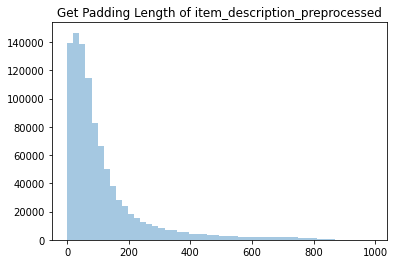

In [ ]:
get_padding_len(X_train,'item_description_preprocessed')

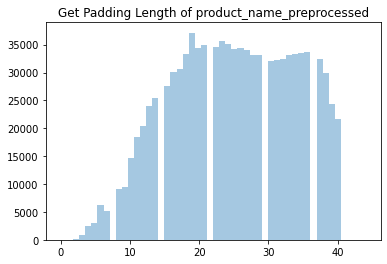

In [ ]:
get_padding_len(X_train,'product_name_preprocessed')

In [ ]:
def tokenize_text(X_train,X_test,col):
  from keras.preprocessing.text import Tokenizer

  tokenize=Tokenizer()
  tokenize.fit_on_texts(X_train[col])
  tok_train = tokenize.texts_to_sequences(X_train[col])
  tok_test = tokenize.texts_to_sequences(X_test[col])

  return tok_train,tok_test,tokenize


In [ ]:
X_train_item_desc_tok,X_test_item_desc_tok,tokenize_desc= tokenize_text(X_train,X_test,'item_description_preprocessed')
X_train_prod_name_tok,X_test_prod_name_tok,tokenize_name = tokenize_text(X_train,X_test,'product_name_preprocessed')

In [ ]:
def pad_text(X_train,X_test,max):

  train_pad=pad_sequences(X_train,maxlen = max, padding='pre')
  test_pad=pad_sequences(X_test,maxlen = max, padding='pre')

  return train_pad,test_pad

In [ ]:
X_train_item_desc_pad,X_test_item_desc_pad = pad_text(X_train_item_desc_tok,X_test_item_desc_tok,650)
X_train_prod_name_pad,X_test_prod_name_pad = pad_text(X_train_prod_name_tok,X_test_prod_name_tok,40)

In [ ]:
X_train_prod_name_pad.shape

(980175, 40)

In [ ]:
def embedding_matrix(tokenizer):

  pickle_in = open("/content/drive/My Drive/Assignments_DonorsChoose_2018/glove_vectors","rb")
  glove_words = pickle.load(pickle_in)    

  embedding_mat = zeros((len(tokenizer.word_index) + 1, 300))
  for word, i in tokenizer.word_index.items():
      vector = glove_words.get(word)
      if vector is not None:
          embedding_mat[i] = vector  

  return  embedding_mat

In [ ]:
embedd_desc=embedding_matrix(tokenize_desc)
embedd_name=embedding_matrix(tokenize_name)

In [ ]:
embedd_name.shape

(83235, 300)

In [ ]:
def create_lstm_model(tokenize_name,embedd_name,tokenize_desc,embedd_desc,ship_size,ship_emsize,brand_size,brand_emsize,item_con_size,item_con_emsize,cat1_size,cat1_emsize,cat2_size,cat2_emsize,cat3_size,cat3_emsize,cat4_size,cat4_emsize,cat5_size,cat5_emsize,NUM_LEN):

  name = Input(shape=(40,),name="product_name")
  embedding_layer = Embedding(len(tokenize_name.word_index) + 1,300,weights=[embedd_name],input_length=40,trainable=False)
  x = embedding_layer(name)
  x = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
  flatten_1 = Flatten()(x)

  desc = Input(shape=(650,),name="item_description_preprocessed")
  embedding_layer = Embedding(len(tokenize_desc.word_index) + 1,300,weights=[embedd_desc],input_length=650,trainable=False)
  x = embedding_layer(desc)
  x = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
  flatten_2 = Flatten()(x)

  shipping=Input(shape=(1,), name='SHIPPING')
  x = Embedding(ship_size + 1, ship_emsize, trainable=True)(shipping)
  flatten_3 = Flatten()(x)

  brand=Input(shape=(1,), name='BRAND')
  x = Embedding(brand_size + 1, brand_emsize, trainable=True)(brand)
  flatten_4 = Flatten()(x)

  item_con=Input(shape=(1,), name='ITEM_CON')
  x = Embedding(item_con_size + 1, item_con_emsize,trainable=True)(item_con)
  flatten_5 = Flatten()(x)

  cat1=Input(shape=(1,), name='CAT1')
  x = Embedding(cat1_size + 1, cat1_emsize, trainable=True)(cat1)
  flatten_6 = Flatten()(x)

  cat2=Input(shape=(1,), name='CAT2')
  x = Embedding(cat2_size + 1, cat2_emsize, trainable=True)(cat2)
  flatten_7 = Flatten()(x)

  cat3=Input(shape=(1,), name='CAT3')
  x = Embedding(cat3_size + 1, cat3_emsize, trainable=True)(cat3)
  flatten_8 = Flatten()(x)

  cat4=Input(shape=(1,), name='CAT4')
  x = Embedding(cat4_size + 1, cat4_emsize, trainable=True)(cat4)
  flatten_9 = Flatten()(x)

  cat5=Input(shape=(1,), name='CAT5')
  x = Embedding(cat5_size + 1, cat5_emsize,trainable=True)(cat5)
  flatten_10 = Flatten()(x)

  numerical_feats = Input(shape=(NUM_LEN,),name="numerical_features")
  numerical_feat = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(numerical_feats)

  x = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,flatten_7,flatten_8,flatten_9,flatten_10,numerical_feat])
  x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
  x=Dropout(0.5)(x)
  x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
  x=Dropout(0.5)(x)
  x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  output = Dense(2, activation='softmax', name='output')(x)

  model = Model(inputs=[name,desc,shipping,brand,item_con,cat1,cat2,cat3,cat4,cat5,numerical_feats],outputs=[output])

  return model


In [ ]:
model=create_lstm_model(tokenize_name,embedd_name,tokenize_desc,embedd_desc,ship_size,ship_emsize,brand_size,brand_emsize,item_con_size,item_con_emsize,cat1_size,cat1_emsize,cat2_size,cat2_emsize,cat3_size,cat3_emsize,cat4_size,cat4_emsize,cat5_size,cat5_emsize,X_num_train.shape[1])

In [ ]:
final_X_train=[X_train_prod_name_pad,X_train_item_desc_pad,X_train_enc_shipping,X_train_brand_name,X_train_enc_item_condition,X_train_category1,X_train_category2,X_train_category3,X_train_category4,X_train_category5,X_num_train]
final_X_test=[X_test_prod_name_pad,X_test_item_desc_pad,X_test_enc_shipping,X_test_brand_name,X_test_enc_item_condition,X_test_category1,X_test_category2,X_test_category3,X_test_category4,X_test_category5,X_num_test]

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_name (InputLayer)       [(None, 40)]         0                                            
__________________________________________________________________________________________________
item_description_preprocessed ( [(None, 650)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      17374200    product_name[0][0]               
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 650, 300)     27707100    item_description_preprocessed[0][
_______________________________________________________________________________________

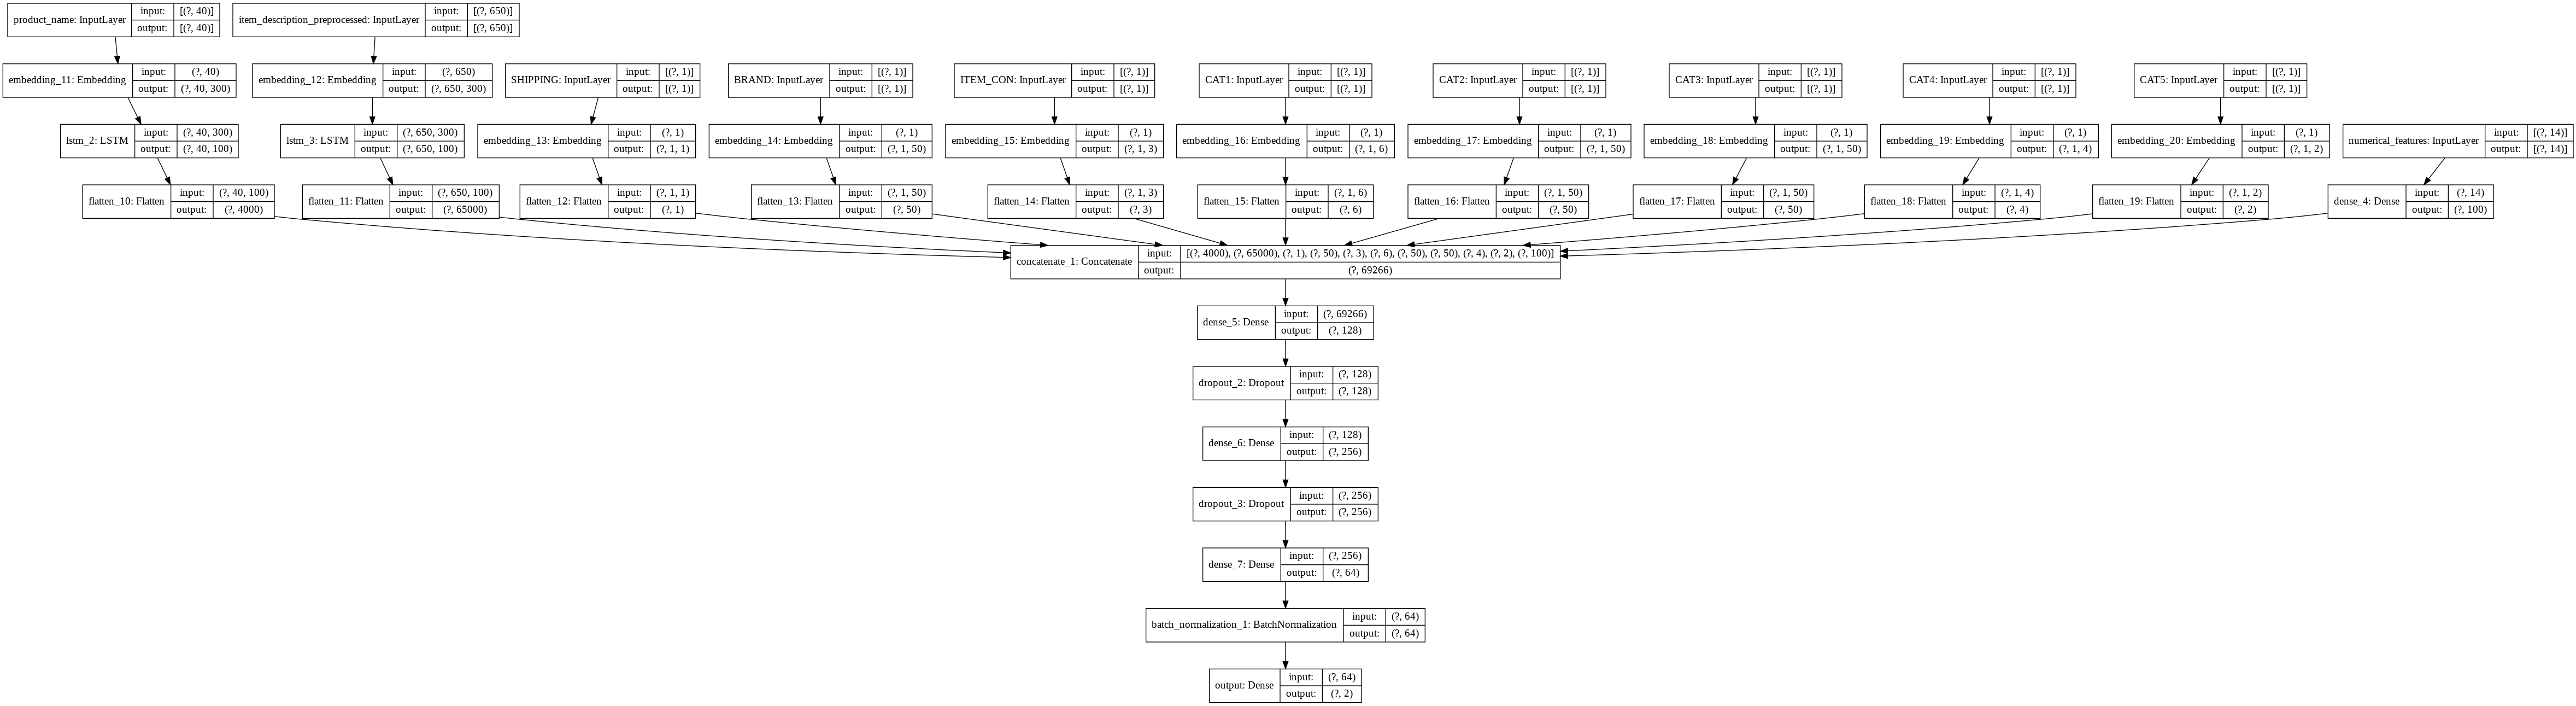

In [ ]:
plot_model(model, to_file='create_lstm_model.png', show_shapes=True, show_layer_names=True)
Image(filename='create_lstm_model.png')

In [ ]:
model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(3e-3))
path='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True ,mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
history = model.fit(final_X_train,y_train, batch_size=2048,epochs=20, verbose=1, validation_data=(final_X_test, y_test),callbacks = callback_list)

Epoch 1/20
245/245 [==============================] - ETA: 0s - loss: 7.2133
Epoch 00001: val_loss improved from inf to 7.04341, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-7.043406-7.043406.h5
245/245 [==============================] - 647s 3s/step - loss: 7.2133 - val_loss: 7.0434
Epoch 2/20
245/245 [==============================] - ETA: 0s - loss: 7.0485
Epoch 00002: val_loss improved from 7.04341 to 7.03705, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-002-7.037053-7.037053.h5
245/245 [==============================] - 633s 3s/step - loss: 7.0485 - val_loss: 7.0371
Epoch 3/20
245/245 [==============================] - ETA: 0s - loss: 7.0469
Epoch 00003: val_loss improved from 7.03705 to 7.03697, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-003-7.036970-7.036970.h5
245/245 [==============================] - 632s 3s/step - loss: 7.0469 - val_loss: 7.0370
Epoch 4/20
245

In [ ]:
best_model = model
best_model.load_weights('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-004-7.036969-7.036969.h5')

In [ ]:
preds = best_model.predict(final_X_test,batch_size = 2048,verbose = 1)[:, 0]
y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
print('RMSLE of Test set is ',rmsle_score(np.expm1(y_test) , y_pred))

98/98 [==============================] - 45s 457ms/step
RMSLE of Test set is  2.6527501267682196


# **MLP MODEL**

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

## **Define MLP Models**

In [ ]:
def mlp_model(train_data):

  Input_layer=Input(shape=(train_data.shape[1],))
  #L1=Dense(1024, activation='relu')(Input_layer)
  L2=Dense(512, activation='relu')(Input_layer)
  L3=Dense(256, activation='relu')(L2)
  L4=Dense(128, activation='relu')(L3)
  L5=Dense(64, activation='relu')(L4)
  L6=Dense(32, activation='relu')(L5)
  out=Dense(1)(L6)
  model=Model(Input_layer,out)

  return model

In [ ]:
def mlp_model2(train_data):

  Input_layer=Input(shape=(train_data.shape[1],))
  L1=Dense(1024, activation='relu')(Input_layer)
  L2=Dense(512, activation='relu')(L1)
  L3=Dense(256, activation='relu')(L2)
  L4=Dense(128, activation='relu')(L3)
  L5=Dense(64, activation='relu')(L4)
  L6=Dense(32, activation='relu')(L5)
  out=Dense(1)(L6)
  model=Model(Input_layer,out)

  return model

In [ ]:
def mlp_model3(train_data):

  Input_layer=Input(shape=(train_data.shape[1],))
  Input_lay=Dense(2046, activation='relu')(Input_layer)
  L1=Dense(1024, activation='relu')(Input_lay)
  L2=Dense(512, activation='relu')(L1)
  L3=Dense(256, activation='relu')(L2)
  L4=Dense(128, activation='relu')(L3)
  L5=Dense(64, activation='relu')(L4)
  L6=Dense(32, activation='relu')(L5)
  out=Dense(1)(L6)
  model=Model(Input_layer,out)

  return model

In [ ]:
def mlp_model4(train_data):

  Input_layer=Input(shape=(train_data.shape[1],))
  #Input_lay=Dense(2046, activation='relu')(Input_layer)
  L1=Dense(1024, activation='relu')(Input_layer)
  L2=Dense(512, activation='relu')(L1)
  L3=Dense(256, activation='relu')(L2)
  L4=Dense(128, activation='relu')(L3)
  L5=Dense(64, activation='relu')(L4)
  L6=Dense(32, activation='relu')(L5)
  out=Dense(1)(L6)
  model=Model(Input_layer,out)

  return model

## **MLP W2V**

In [ ]:
mlp_model=mlp_model(X_tr_avg_W2Ve)
mlp_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7093)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               3632128   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [ ]:
mlp_model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=3e-3))
path='model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
for i in range(4):
  mlp_model.fit(X_tr_avg_W2Ve, y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_te_avg_W2Ve, y_test),callbacks = callback_list)
  preds = mlp_model.predict(X_te_avg_W2Ve)[:, 0]
  y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
  print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(np.expm1(y_test) , y_pred),'\n')

1953/1954 [============================>.] - ETA: 0s - loss: 0.2682
Epoch 00001: val_loss improved from inf to 0.22536, saving model to model-001-0.225362-0.225362.h5
1954/1954 [==============================] - 19s 10ms/step - loss: 0.2682 - val_loss: 0.2254
Test RMSLE for batch size =  256  is  0.47472303289454476 

975/977 [============================>.] - ETA: 0s - loss: 0.2102
Epoch 00001: val_loss did not improve from 0.22536
977/977 [==============================] - 18s 19ms/step - loss: 0.2102 - val_loss: 0.2280
Test RMSLE for batch size =  512  is  0.47750792529627467 

486/489 [============================>.] - ETA: 0s - loss: 0.1907
Epoch 00001: val_loss improved from 0.22536 to 0.20759, saving model to model-001-0.207586-0.207586.h5
489/489 [==============================] - 17s 35ms/step - loss: 0.1907 - val_loss: 0.2076
Test RMSLE for batch size =  1024  is  0.4556156137041203 

244/245 [============================>.] - ETA: 0s - loss: 0.1762
Epoch 00001: val_loss impr

## **MLP TFIDFW2V**

In [ ]:
mlp_model=mlp_model(X_tr_tfidf_W2V)
mlp_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7093)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3632128   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
mlp_model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=3e-3))
path='model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
for i in range(4):
  mlp_model.fit(X_tr_tfidf_W2V, y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_te_tfidf_W2V, y_test),callbacks = callback_list)
  preds = mlp_model.predict(X_te_tfidf_W2V)[:, 0]
  y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
  print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(np.expm1(y_test) , y_pred),'\n')

   1/1954 [..............................] - ETA: 0s - loss: 10.2601WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1953/1954 [============================>.] - ETA: 0s - loss: 0.2824
Epoch 00001: val_loss improved from inf to 0.23108, saving model to model-001-0.231084-0.231084.h5
1954/1954 [==============================] - 18s 9ms/step - loss: 0.2824 - val_loss: 0.2311
Test RMSLE for batch size =  256  is  0.48071158275549214 

972/977 [============================>.] - ETA: 0s - loss: 0.2164
Epoch 00001: val_loss improved from 0.23108 to 0.22329, saving model to model-001-0.223295-0.223295.h5
977/977 [==============================] - 17s 17ms/step - loss: 0.2164 - val_loss: 0.2233
Test RMSLE for batch size =  512  is  0.47254056695092755 

486/489 [======

## **MLP TFIDF**

In [ ]:
mlp_model=mlp_model(X_tr_tfidf)
mlp_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189691)]          0         
_________________________________________________________________
dense (Dense)                (None, 512)               97122304  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
mlp_model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(3e-3))
path='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True ,mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
for i in range(4):
  mlp_model.fit(X_tr_tfidf, y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_te_tfidf, y_test),callbacks = callback_list)
  preds = mlp_model.predict(X_te_tfidf)[:, 0]
  y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
  print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(np.expm1(y_test) , y_pred),'\n')

   1/3829 [..............................] - ETA: 14s - loss: 9.6222WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3827/3829 [============================>.] - ETA: 0s - loss: 0.2148
Epoch 00001: val_loss improved from inf to 0.17745, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.177448-0.177448.h5
3829/3829 [==============================] - 35s 9ms/step - loss: 0.2148 - val_loss: 0.1774
Test RMSLE for batch size =  256  is  0.4212456995260649 

1915/1915 [==============================] - ETA: 0s - loss: 0.1425
Epoch 00001: val_loss improved from 0.17745 to 0.16419, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.164193-0.164193.h5
1915/1915 [==============================] - 

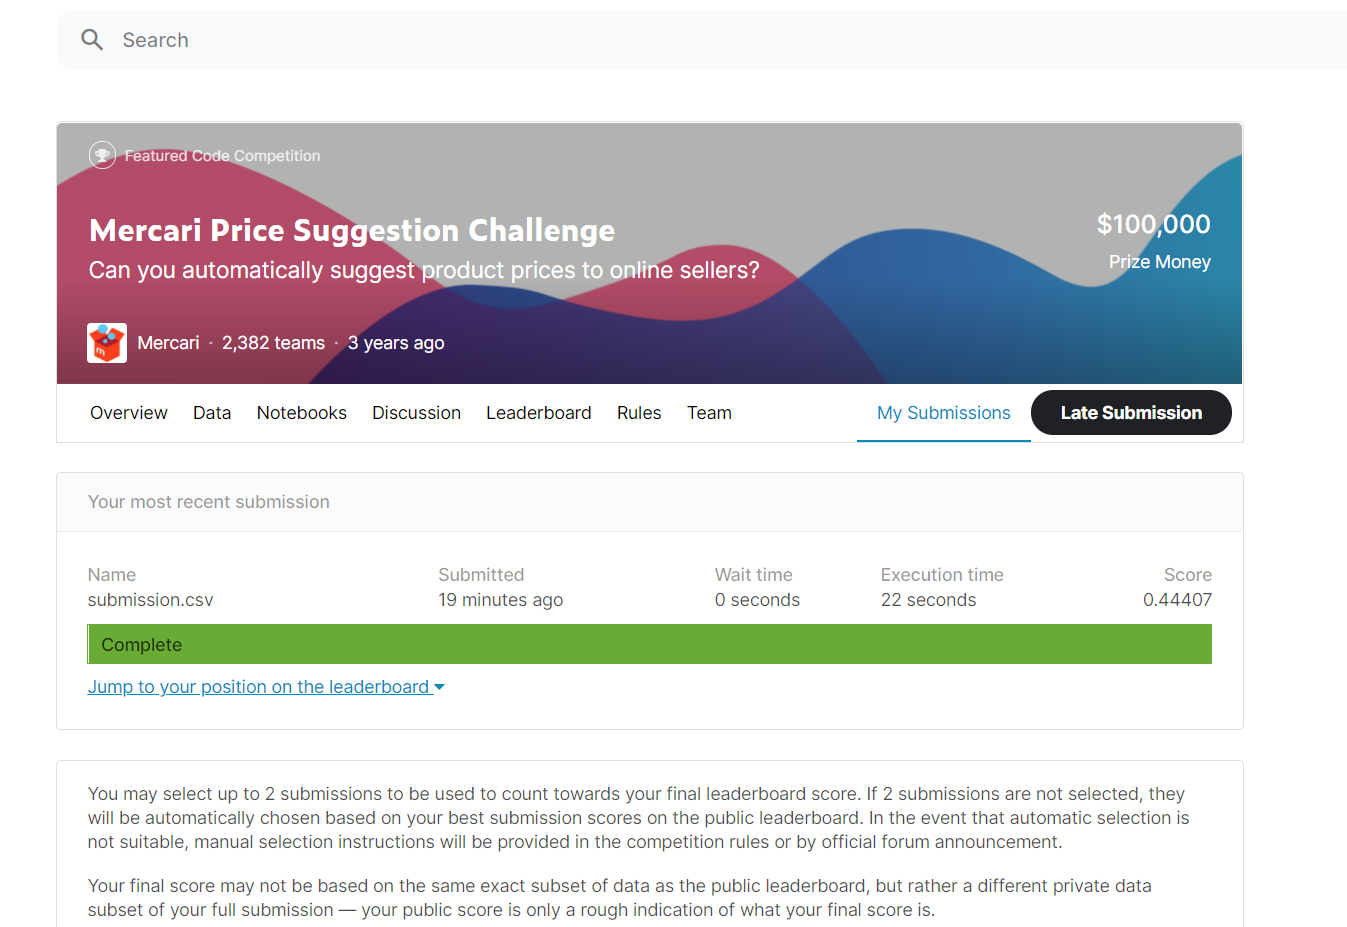

In [ ]:
Image(filename='/content/drive/My Drive/Kaggle/Mercari/approach_1/MLP_Kaggle_Score.PNG')

In [ ]:
best_model = mlp_model
best_model.load_weights('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-002-0.171182-0.171182.h5')

In [ ]:
mlp_model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(3e-3))
path='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True ,mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
history = mlp_model.fit(X_tr_tfidf, y_train, batch_size=512,epochs=20, verbose=1, validation_data=(X_te_tfidf, y_test),callbacks = callback_list)

Epoch 1/20
   1/1915 [..............................] - ETA: 11s - loss: 0.1131WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1913/1915 [============================>.] - ETA: 0s - loss: 0.1117
Epoch 00001: val_loss improved from inf to 0.17235, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.172353-0.172353.h5
1915/1915 [==============================] - 30s 16ms/step - loss: 0.1117 - val_loss: 0.1724
Epoch 2/20
1914/1915 [============================>.] - ETA: 0s - loss: 0.0893
Epoch 00002: val_loss improved from 0.17235 to 0.17118, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-002-0.171182-0.171182.h5
1915/1915 [==============================] - 27s 14ms/step - loss: 0.0893 - val_l

In [ ]:
best_model = mlp_model
best_model.load_weights('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-002-0.171182-0.171182.h5')

In [ ]:
preds = best_model.predict(X_te_tfidf,batch_size = 512,verbose = 1)[:, 0]
y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
print('RMSLE of Test set is ',rmsle_score(np.expm1(y_test) , y_pred))

943/943 [==============================] - 2s 2ms/step
RMSLE of Test set is  0.41374123071711216


In [ ]:
mlp_model2=mlp_model2(X_tr_tfidf)
mlp_model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 189691)]          0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              194244608 
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [ ]:
mlp_model2.compile(loss='mean_squared_error', optimizer=optimizers.Adam(3e-3))
path='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True ,mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
for i in range(4):
  mlp_model2.fit(X_tr_tfidf, y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_te_tfidf, y_test),callbacks = callback_list)
  preds = mlp_model2.predict(X_te_tfidf)[:, 0]
  y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
  print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(np.expm1(y_test) , y_pred),'\n')

   1/3829 [..............................] - ETA: 31s - loss: 9.7221WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3826/3829 [============================>.] - ETA: 0s - loss: 0.2312
Epoch 00001: val_loss improved from inf to 0.17705, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.177054-0.177054.h5
3829/3829 [==============================] - 58s 15ms/step - loss: 0.2311 - val_loss: 0.1771
Test RMSLE for batch size =  256  is  0.4207772230206827 

1914/1915 [============================>.] - ETA: 0s - loss: 0.1388
Epoch 00001: val_loss improved from 0.17705 to 0.16405, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.164046-0.164046.h5
1915/1915 [==============================] -

In [ ]:
mlp_model3=mlp_model3(X_tr_tfidf)
mlp_model3.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189691)]          0         
_________________________________________________________________
dense (Dense)                (None, 2046)              388109832 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2096128   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [ ]:
mlp_model3.compile(loss='mean_squared_error', optimizer=optimizers.Adam(3e-3))
path='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True ,mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
for i in range(3):
  mlp_model3.fit(X_tr_tfidf, y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_te_tfidf, y_test),callbacks = callback_list)
  preds = mlp_model3.predict(X_te_tfidf)[:, 0]
  y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
  print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(np.expm1(y_test) , y_pred),'\n')

3829/3829 [==============================] - ETA: 0s - loss: 0.2310
Epoch 00001: val_loss improved from inf to 0.17381, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.173807-0.173807.h5
3829/3829 [==============================] - 102s 27ms/step - loss: 0.2310 - val_loss: 0.1738
Test RMSLE for batch size =  256  is  0.41690190290874646 

1914/1915 [============================>.] - ETA: 0s - loss: 0.1361
Epoch 00001: val_loss improved from 0.17381 to 0.16328, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.163283-0.163283.h5
1915/1915 [==============================] - 61s 32ms/step - loss: 0.1361 - val_loss: 0.1633
Test RMSLE for batch size =  512  is  0.404083460488152 

958/958 [==============================] - ETA: 0s - loss: 0.0899
Epoch 00001: val_loss did not improve from 0.16328
958/958 [==============================] - 31s 33ms/step - loss: 0.0899 - val_loss: 0.1637
Test RMSLE for batch size =  

In [ ]:
mlp_model4=mlp_model4(X_tr_tfidf)
mlp_model4.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 189691)]          0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              194244608 
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [ ]:
mlp_model4.compile(loss='mean_squared_error', optimizer=optimizers.Adam(3e-3))
path='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-{epoch:03d}-{val_loss:03f}-{val_loss:03f}.h5'
checkpoint = ModelCheckpoint(filepath=path, verbose=1, monitor='val_loss',save_best_only=True, save_weights_only=True ,mode='min')  
tensorboard=TensorBoard(log_dir='/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Logs')
callback_list=[checkpoint,tensorboard]

In [ ]:
for i in range(15):
  mlp_model4.fit(X_tr_tfidf, y_train, batch_size=100*i, epochs=1, verbose=1, validation_data=(X_te_tfidf, y_test),callbacks = callback_list)
  preds = mlp_model4.predict(X_te_tfidf)[:, 0]
  y_pred = np.expm1((preds.reshape(-1, 1))[:, 0])
  print('Test RMSLE for batch size = ',100*i,' is ',rmsle_score(np.expm1(y_test) , y_pred),'\n')

    1/30631 [..............................] - ETA: 6:17 - loss: 11.6423WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30629/30631 [============================>.] - ETA: 0s - loss: 0.2018
Epoch 00001: val_loss improved from inf to 0.17676, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.176758-0.176758.h5
30631/30631 [==============================] - 566s 18ms/step - loss: 0.2018 - val_loss: 0.1768
Test RMSLE for batch size =  0  is  0.42042635483836277 

9800/9802 [============================>.] - ETA: 0s - loss: 0.1439
Epoch 00001: val_loss improved from 0.17676 to 0.16416, saving model to /content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.164155-0.164155.h5
9802/9802 [=========================

# **Ensemble Models**

## **LGBM Ensemble**

In [ ]:
LGBM_1 = pickle.load(open('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/LGBM_best15000.pkl',"rb"))
preds_LGBM_1=np.expm1(LGBM_1.predict(X_te_tfidf))

In [ ]:
LGBM_2 = pickle.load(open('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/LGBM_best10000.pkl',"rb"))
preds_LGBM_2=np.expm1(LGBM_2.predict(X_te_tfidf))

In [ ]:
weights=np.linspace(0,1,50)
weight_score={}
score=[]

for i in weights:
  pred=(i*preds_LGBM_1) + (1-i)*(preds_LGBM_2)
  score.append(rmsle_score(np.expm1(y_test),pred))
  weight_score.setdefault(i,score)

df=pd.DataFrame.from_dict({'weights' : weights,'scores':score})
df.sort_values('scores',inplace=True)
df.head()

,weights,scores
49,1.000000,0.408124
48,0.979592,0.408152
47,0.959184,0.408182
46,0.938776,0.408212
45,0.918367,0.408243


In [ ]:
pred_final_LGBM=(1.000000*preds_LGBM_1) + ((1-1.000000)*preds_LGBM_2)

## **MLP-MLP**

In [ ]:
model = mlp_model3
model.load_weights('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.163283-0.163283.h5')
preds = model.predict(X_te_tfidf,batch_size = 512,verbose = 1)[:, 0]
preds_mlp3=np.expm1((preds.reshape(-1, 1))[:, 0])

943/943 [==============================] - 2s 2ms/step


In [ ]:
model = mlp_model4
model.load_weights('/content/drive/My Drive/Kaggle/Mercari/approach_1/DL_Models/model-001-0.162473-0.162473.h5')
preds = model.predict(X_te_tfidf,batch_size = 200,verbose = 1)[:, 0]
preds_mlp4=np.expm1((preds.reshape(-1, 1))[:, 0])

2414/2414 [==============================] - 4s 1ms/step


In [ ]:
weights=np.linspace(0,1,50)
weight_score={}
score=[]

for i in weights:
  pred=(i*preds_mlp4) + (1-i)*(preds_mlp3)
  score.append(rmsle_score(np.expm1(y_test),pred))
  weight_score.setdefault(i,score)

df=pd.DataFrame.from_dict({'weights' : weights,'scores':score})
df.sort_values('scores',inplace=True)
df.head()

,weights,scores
25,0.510204,0.392827
24,0.489796,0.392835
26,0.530612,0.392855
23,0.469388,0.392877
27,0.551020,0.392917


In [ ]:
pred_final_mlp=(0.510204*preds_mlp4) + ((1-0.510204)*preds_mlp3)

## **LGBM + MLP Ensemble**



In [ ]:
weights=np.linspace(0,1,50)
weight_score={}
score=[]

for i in weights:
  pred=(i*pred_final_LGBM) + (1-i)*(pred_final_mlp)
  score.append(rmsle_score(np.expm1(y_test),pred))
  weight_score.setdefault(i,score)

df=pd.DataFrame.from_dict({'weights' : weights,'scores':score})
df.sort_values('scores',inplace=True)
df.head()

,weights,scores
18,0.367347,0.386267
17,0.346939,0.386271
19,0.387755,0.386305
16,0.326531,0.386317
20,0.408163,0.386384


In [ ]:
pred_final_ensemble=(0.367347*pred_final_LGBM) + ((1-0.367347)*pred_final_mlp)

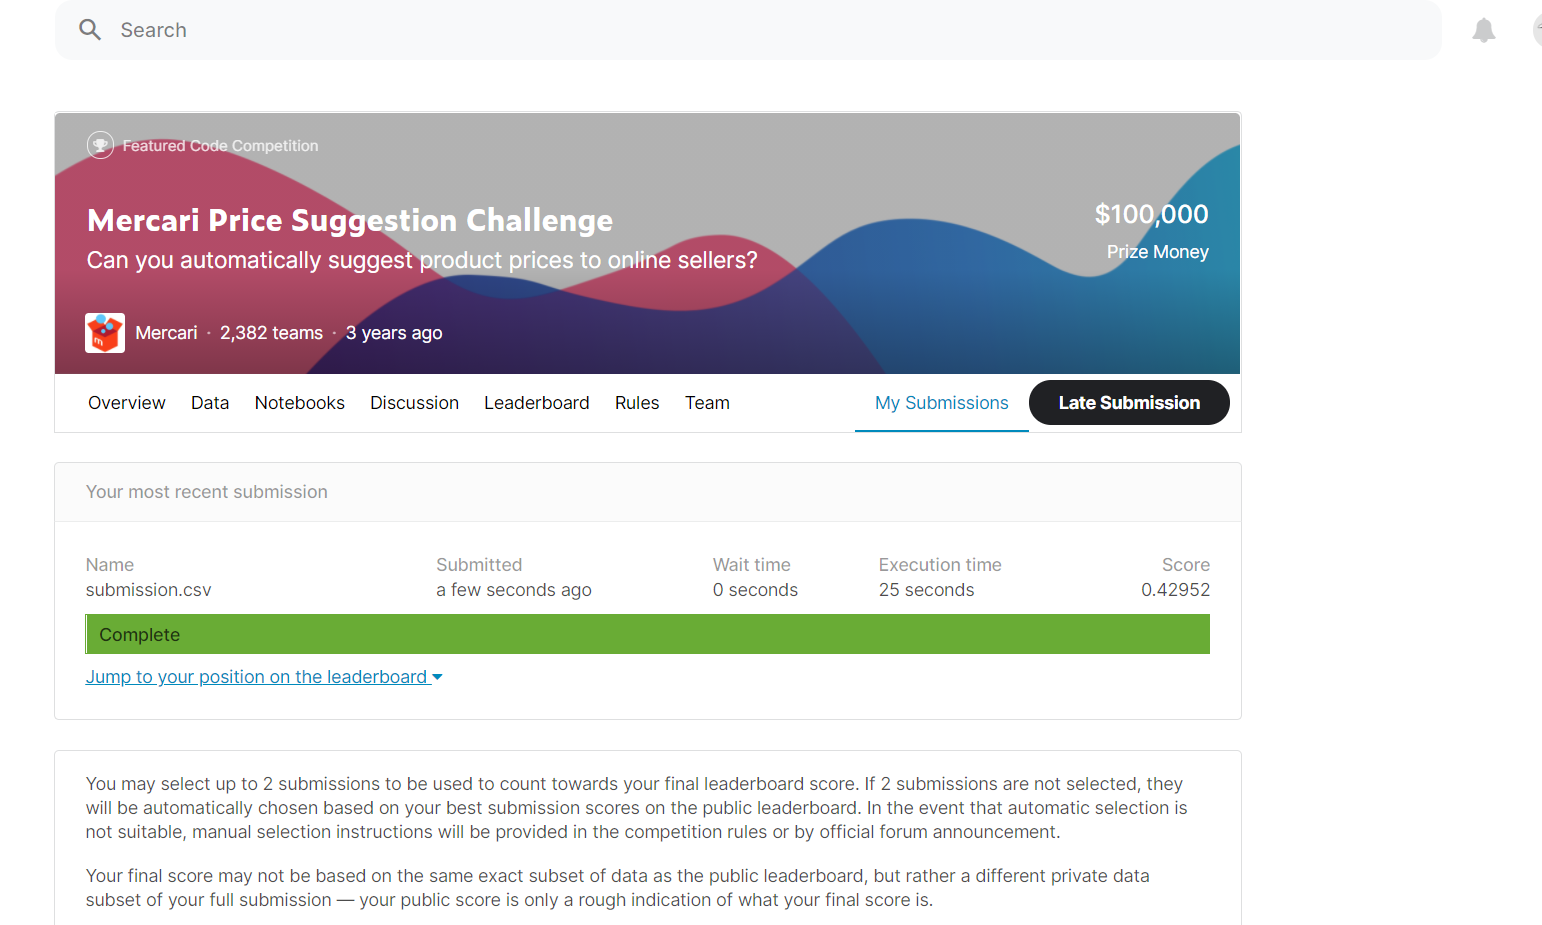

In [4]:
Image(filename='/content/drive/My Drive/Kaggle/Mercari/approach_1/Kaggle_42952.PNG')

# **Summary**

In [5]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Vectorizer", "RMSLE"]
x.add_row(["RIDGE","AVGW2V", "0.5112377791430355"])
x.add_row(["RIDGE","TFIDFW2V", "0.514569518482207 "])
x.add_row(["RIDGE","TFIDF", "0.46434835765133164"])
x.add_row(["CATBOOST","AVGW2V", "0.5225612222843662"])
x.add_row(["CATBOOST","TFIDFW2V", "0.5274921512295363"])
x.add_row(["CATBOOST","TFIDF", "0.4298074787352844"])
x.add_row(["LGBM","AVGW2V", "0.45095808880706106 "])
x.add_row(["LGBM","TFIDFW2V", "0.45583672579208045"])
x.add_row(["LGBM1","TFIDF", "0.41060725975568774"])
x.add_row(["LGBM2","TFIDF", "0.4081239058992117  "])
x.add_row(["LSTM","Glove Embeddings", "2.6527501267682196"])
x.add_row(["MLP","AVGW2V", "0.45022396430412903"])
x.add_row(["MLP","TFIDFW2V", "0.45627606688495953"])
x.add_row(["MLP","TFIDF", "0.40520726688030817"])
x.add_row(["MLP+LGBM","TFIDF", "0.386267"])
print(x)

+----------+------------------+----------------------+
|  Model   |    Vectorizer    |        RMSLE         |
+----------+------------------+----------------------+
|  RIDGE   |      AVGW2V      |  0.5112377791430355  |
|  RIDGE   |     TFIDFW2V     |  0.514569518482207   |
|  RIDGE   |      TFIDF       | 0.46434835765133164  |
| CATBOOST |      AVGW2V      |  0.5225612222843662  |
| CATBOOST |     TFIDFW2V     |  0.5274921512295363  |
| CATBOOST |      TFIDF       |  0.4298074787352844  |
|   LGBM   |      AVGW2V      | 0.45095808880706106  |
|   LGBM   |     TFIDFW2V     | 0.45583672579208045  |
|  LGBM1   |      TFIDF       | 0.41060725975568774  |
|  LGBM2   |      TFIDF       | 0.4081239058992117   |
|   LSTM   | Glove Embeddings |  2.6527501267682196  |
|   MLP    |      AVGW2V      | 0.45022396430412903  |
|   MLP    |     TFIDFW2V     | 0.45627606688495953  |
|   MLP    |      TFIDF       | 0.40520726688030817  |
| MLP+LGBM |      TFIDF       |       0.386267       |
+---------

**Model Summary**

*   The Top two best models are MLP anf LGBM with TFIDF vectorizers 
*   The Best Model is Ensemble of LGBM and MLP with TFIDF vectorizers





